In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
GOOD_REVIEW_THRESHOLD = 7

In [4]:
VAL_FRACTION = 0.25

In [5]:
MIN_COMMENT_LEN = 25

In [6]:
TOP_N = 5

## GET DATA

In [7]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [8]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [9]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '316624',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/eUiju5SqZbkNt8gnEofrTw__thumb/img/zNkmLNyeXJGOY24FeAAf4U67ejU=/fit-in/200x150/filters:strip_icc()/pic6035127.png',
  'name': 'Stationfall',
  'yearpublished': '2021'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [72]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,316624,abubrooklyn,10,Do yourself a favor and play this game.
1,316624,ajewo,N/A,Stationsfall seems to be similar to Nemesis. ...
2,316624,Andy Mesa,10,This game tells the best stories of any game I...
3,316624,BGG_is_racist55,10,"BGG is racist, deletes uncomfortable opinions,..."
4,316624,bigduff,N/A,Backed on KS (Crowdfinder)
...,...,...,...,...
89550,167791,z_zadar,9,Some games are so much fun. Others can be a li...
89551,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
89552,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
89553,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [73]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [74]:
comments_df["value"] = comments_df["value"].astype(str)

In [75]:
# REMOVE URLs FROM COMMENTS

In [76]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [81]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    df_local = df.copy()
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [85]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15196 for 'remove_short_comments' - min len: 25 - method: unrated


In [86]:
# REMOVE NON ENGLISH COMMENTS

In [87]:
# !conda install -c conda-forge langdetect

In [88]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [89]:
# comments_df = add_comments_lang(comments_df)

In [90]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [91]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0                 14730
9.0                  14177
8.0                  11874
7.0                   6354
N/A                   6177
                     ...  
9.982000000000001        1
8.971                    1
8.522219999999999        1
9.53333                  1
8.677999999999999        1
Name: rating, Length: 511, dtype: int64

In [92]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(68182, 5)

In [93]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6177, 5)

## CREATE TRAINING AND VALIDATION DATA

In [94]:
# use rated comments (reviews) to train the model

In [95]:
rated_comments = rated_comments.sample(frac=1)

In [96]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [97]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'1 Play.  Good game.'

In [98]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'I can’t bring myself to enjoy Scythe after several plays. I’m not a fan of how many turns feel like optimization puzzles where your move is dictated by the board game. Taking the initiative to do something different means making a losing move. In many cases, the board will completely restrict you from doing what you want unless you make a series of suboptimal moves over multiple rounds to get resources.'

In [99]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [100]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.19236672, -0.13765024,  0.08825514,  0.11757579,  0.10254589,
        -0.2013054 , -0.1684449 ,  0.15349093, -0.14583522,  0.01703295,
         0.16671634,  0.11791452,  0.15511073,  0.00932512,  0.21257403,
         0.08852971,  0.39651132,  0.10162947,  0.04218949, -0.19841024,
         0.06608517, -0.16845424,  0.02857848,  0.21522808, -0.18306321,
        -0.12576166, -0.16180296, -0.09230065, -0.08688274, -0.04802217,
         0.18422134,  0.02087962, -0.20942453, -0.05498395,  0.08335619,
         0.09036979,  0.07633591, -0.17406985,  0.10116608, -0.2244031 ,
         0.1553969 , -0.08052192, -0.08636334, -0.16995242,  0.02367644,
         0.00781853, -0.0187955 , -0.03384756,  0.08075846,  0.08742364],
       [ 0.64265734, -0.02005985,  0.0315392 ,  0.5728946 , -0.17068051,
        -0.22647579,  0.41508216,  0.12395759, -0.63278735,  0.0310485 ,
         0.05918314,  0.26601928, -0.02865938, -0.05895287, -0.15333247,
 

In [101]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [103]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Train on 51137 samples, validate on 17045 samples
Epoch 1/40
51137/51137 - 30s - loss: 0.5199 - accuracy: 0.8088 - val_loss: 0.3976 - val_accuracy: 0.8582
Epoch 2/40
51137/51137 - 30s - loss: 0.3388 - accuracy: 0.8588 - val_loss: 0.3175 - val_accuracy: 0.8659
Epoch 3/40
51137/51137 - 30s - loss: 0.2757 - accuracy: 0.8878 - val_loss: 0.2958 - val_accuracy: 0.8838
Epoch 4/40
51137/51137 - 30s - loss: 0.2362 - accuracy: 0.9069 - val_loss: 0.2934 - val_accuracy: 0.8852
Epoch 5/40
51137/51137 - 30s - loss: 0.2068 - accuracy: 0.9198 - val_loss: 0.3034 - val_accuracy: 0.8844
Epoch 6/40
51137/51137 - 30s - loss: 0.1842 - accuracy: 0.9300 - val_loss: 0.3185 - val_accuracy: 0.8798
Epoch 7/40
51137/51137 - 30s - loss: 0.1652 - accuracy: 0.9388 - val_loss: 0.3410 - val_accuracy: 0.8759
Epoch 8/40
51137/51137 - 30s - loss: 0.1500 - accuracy: 0.9455 - val_loss: 0.3643 - val_accuracy: 0.8713
Epoch 9/40
51137/51137 - 30s - loss: 0.1372 - accuracy: 0.9516 - val_loss: 0.3904 - val_accuracy: 0.8699


In [104]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [105]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [106]:
epochs = range(1, len(acc) + 1) 

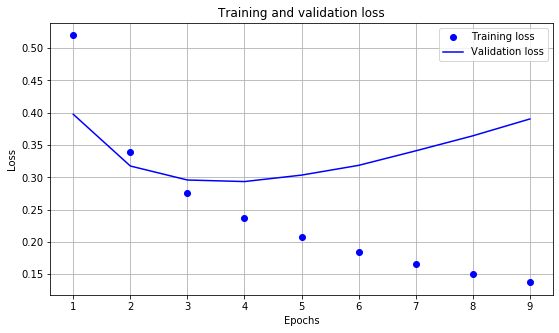

In [107]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

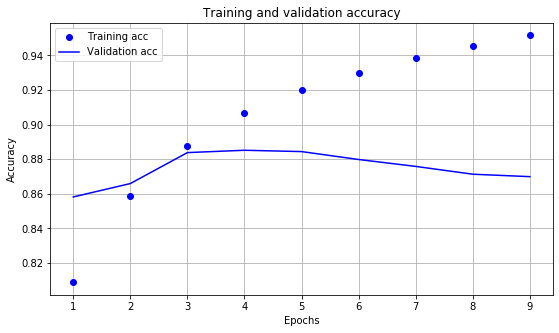

In [108]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [109]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [110]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"A game with a theme and feeling as smooth as the gameplay itself. Scythe is a beautiful experience that captures the unique feeling of life in contested territory, the threat of war, and the repercussions of conflict. It is one of few board games that are not only REALLY fun, but artistic in nature. "
score: 0.961389
actual value:1

input:
"Giant beast of a campaign dungeon crawler.  Very well designed, lots of interesting decisions round-to-round, with a wide variety of character archetypes to play."
score: 0.999426
actual value:1

input:
"You don’t really win at Arkham Horror. You barely scrape through, if you manage to survive at all. If you have an issue with loss aversion, this is not the game for you."
score: 0.964781
actual value:1

input:
"Interesting trick-taking cooperative game with a campaign (of sorts) with several games of increasing difficulty. If you like trick-taking games you ought to at least try this one. The single games are very short but they lend themsel

In [111]:
## APPLY MODEL ON NON-RATED COMMENTS

In [112]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"DnD like RPG for loooooong dedicated play"
score: 0.990743

input:
"Played solo first, then BJP (unfinished), BJ, then at game evening 5-player. "
score: 0.991482

input:
"With: Jessica of Arrakis promo card"
score: 0.997296

input:
"2 Core Sets. 1 second print run + 1 First Print Run w/ Errata Stickers"
score: 0.999860

input:
"Think i want this in a luxury edition with nicer pions but definitely want to own. "
score: 0.996556

input:
"Interest: 8/10  Probably best for a 2-player game with spouse"
score: 0.999822

input:
"It fails the prettiness requirement, so I cannot buy it."
score: 0.696425

input:
"I'd prefer the deluxe English edition of this game."
score: 0.737997

input:
"Great game, though would have like some more copies of cards in the core game."
score: 0.966116

input:
"Preordered on Miniatures Market"
score: 0.978815

input:
"Unplayed, but looks like received in trade inside game box. Definitely been opened. "
score: 0.997254

input:
"Don’t want to trade this. Im

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [113]:
rated_comments.head()

,id,username,rating,value,comment_len
26868,281259,skraem,8,1 Play. Good game.,12
60827,266192,pineapplebun,8,It's an excellent bird engine game that can be...,355
25022,169786,bponnaluri,3,I can’t bring myself to enjoy Scythe after sev...,329
37207,233078,Spinners71,10,#1 game of all time! It is everything I could ...,173
68280,169786,quarry,8,kickstarter,11


In [114]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.350014,3480
1,167355,8.418874,1774
2,167791,8.210945,8204
3,169786,8.100929,7304
4,174430,8.550632,6300


In [115]:
rated_comments.query("id==328866")

,id,username,rating,value,comment_len
304,328866,FatherIgnatius,1.0,"Overpriced, and yeah - to hell with board game...",58
307,328866,girman39,9.5,Played at UnPub 2018. Absolutely love this th...,462
322,328866,Werbaer,1.0,Not a boardgame. App required.,24
309,328866,Jack Squat,10.0,It gets a 10 for having an app!,21
299,328866,BGG_is_racist55,10.0,"BGG is racist, deletes uncomfortable opinions,...",535
316,328866,mqstout,1.0,Not a board game. APP REQUIRED TO PLAY. The ga...,121
320,328866,The Chaz,10.0,"A masterpiece, long in the making",27
300,328866,bno70_1,9.0,This game is a true innovation,25
308,328866,ironbend,7.5,atmospheric mipl placement with interesting kn...,52


In [116]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [117]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.881699,306
1,167355,9.002347,213
2,167791,8.934247,438
3,169786,8.805442,588
4,174430,8.719894,568


In [118]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [119]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,162886,8.350014,3480,8.881699,306,20,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886
1,167355,8.418874,1774,9.002347,213,35,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355
2,167791,8.210945,8204,8.934247,438,16,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791
3,169786,8.100929,7304,8.805442,588,36,https://cf.geekdo-images.com/7k_nOxpO9OGIjhLq2...,Scythe,2016,https://boardgamegeek.com/boardgame/169786
4,174430,8.550632,6300,8.719894,568,21,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...,Gloomhaven,2017,https://boardgamegeek.com/boardgame/174430


In [120]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [121]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,162886,8.350014,3480,8.881699,306,20,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886,8.392987
1,167355,8.418874,1774,9.002347,213,35,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355,8.481420
2,167791,8.210945,8204,8.934247,438,16,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791,8.247604
3,169786,8.100929,7304,8.805442,588,36,https://cf.geekdo-images.com/7k_nOxpO9OGIjhLq2...,Scythe,2016,https://boardgamegeek.com/boardgame/169786,8.153420
4,174430,8.550632,6300,8.719894,568,21,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...,Gloomhaven,2017,https://boardgamegeek.com/boardgame/174430,8.564630


In [122]:
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')

In [123]:
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

In [124]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [125]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [126]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.545455,9.520000,9.537500,1,2021
2,,Lost Ruins of Arnak,7.931164,8.483607,7.980216,2,2020
3,,Merchants Cove,8.480556,9.253659,8.892208,3,2021
4,,MicroMacro: Crime City,7.930735,9.106667,8.011279,4,2020
5,,Dune: Imperium,8.120877,8.945833,8.205851,5,2020


In [127]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Galaxy Trucker,10.000000,9.400000,9.500000,40,2021
2,,ICE,9.750000,9.100000,9.620000,42,2022
3,,Stationfall,9.545455,9.520000,9.537500,1,2021
4,,Eclipse: Second Dawn for the Galaxy,8.731950,8.709524,8.728278,41,2020
5,,Kemet: Blood and Sand,8.700000,8.889091,8.830000,47,2021


In [128]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,ICE,9.750000,9.100000,9.620000,42,2022
2,,Stationfall,9.545455,9.520000,9.537500,1,2021
3,,Galaxy Trucker,10.000000,9.400000,9.500000,40,2021
4,,Marvel United: X-Men,8.000000,9.487500,9.322222,19,2022
5,,Merchants Cove,8.480556,9.253659,8.892208,3,2021


In [129]:
# model.save('saved_model\my_model')

In [130]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [131]:
# some examples on "long" comments vs short comments

In [132]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [133]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Got in on the 2nd KS, so far only played the first two scenarios and a couple random setups. One of these days..."
score: 0.995516

input:
"Alien SemiKooperativ Spieler können sterben, spielen dann den bösen Hunter und Cron Platz 3 Geekinge Spiele 2020"
score: 0.918219

input:
"Very good theme and storytelling. The card mechancis are very varied and diffrent missions can be very diffrent from each other. Feels like beeing and Arkham investigator."
score: 0.999927

input:
"I purchased two copies of the Arkham Horror core set to accommodate four players and allow for more diverse deck building."
score: 0.973079

input:
"I think I'd love the puzzle aspect combined with the publishing mechanic, but I don't want a board game that requires an app."
score: 0.987921

input:
"Amazing production quality and art. Worker placement and tableau/engine building, two of my favourite mechanics."
score: 0.999943

input:
"Might not buy (at least not anytime soon), want really intrigued by the ide